# Initializing particle positions
This Notebook creates the initial positions of particles to be fed to the particle tracking simulation.

In [16]:
import pickle
import sys
from pathlib import Path
from typing import TextIO

import h3
import numpy as np
from netCDF4 import Dataset
from scipy.interpolate import griddata
from scipy.io import loadmat

sys.path.insert(1, str(Path.cwd() / 'utils'))
from constants import PARTICLE_DENSITY, LEFT_BOUND, RIGHT_BOUND, TOP_BOUND, BOTTOM_BOUND, RESOLUTION  # noqa: E402
from hexbin import Hexbin  # noqa: E402
from plot import plot_positions, plot_hexbins, plot_contourf  # noqa: E402

## Making positions
Particles are initialized at positions with uniform density over a domain within an acceptable bathymetry range, effectively restricting the domain to all points contained in a bounding box that are within the bathymetry range. Field data is used to do this.

In [2]:
# Read coordinate points
SKIP = 5
fields = Dataset(Path.cwd() / 'data' / 'fields' / 'fall' / 'MLD_SmallGrid_BNAM.nc')
lons = fields['nav_lon_t'][SKIP:]
lats = fields['nav_lat_t'][SKIP:]

# Read MLD data for each coordinate point
mlds = fields['MLD'][:]
mlds = np.array([mld[SKIP:] for mld in mlds])  # Crop each month of MLD values

# Read bathymetry data for each coordinate point
bathy_points = np.concatenate(loadmat(Path.cwd() / 'data' / 'fields' / 'Bathy_SmallGrid_BNAM.mat')['Bathymetry'][SKIP:])

In [3]:
lon_res = RIGHT_BOUND - LEFT_BOUND
lat_res = TOP_BOUND - BOTTOM_BOUND

# Make query points
query_points = np.concatenate(np.mgrid[
                              RIGHT_BOUND:LEFT_BOUND:lon_res * 115j,
                              BOTTOM_BOUND:TOP_BOUND:lat_res * 115j
                              ].T)

# Make field grid
field_grid = np.array((np.concatenate(lons), np.concatenate(lats)), dtype=tuple).T

# Interpolate bathymetry at each query point and save positions within bathy range
bathy = griddata(field_grid, bathy_points, query_points, method='linear')
positions = query_points[np.where(np.logical_and(bathy > 0, bathy <= 510))]

In [4]:
# Compute average MLD at each month
mlds_points = np.array([np.concatenate(mlds_month) for mlds_month in mlds], dtype=object)
mld_grid = np.array([griddata(field_grid, mld_points.T, positions, method='linear') for mld_points in mlds_points], dtype=object)
print([np.average(mld_grid_month) for mld_grid_month in mld_grid])

[10.005145593433236, 15.250718381170971, 21.037795861511693]


In [5]:
domain_nodes = Hexbin.assign_h3_indices(positions[:, 1], positions[:, 0], allow_duplicates=False)
hexbins = [Hexbin(node) for node in domain_nodes]

In [20]:
single_hexbin = hexbins[200]

particles_in_hexbin = 0
for lon, lat in zip(positions[:, 0], positions[:, 1]):
    if single_hexbin.contains(lon, lat):
        particles_in_hexbin += PARTICLE_DENSITY

hexbin_area = h3.cell_area(single_hexbin.h3, unit='km^2')
print(f'ca. {particles_in_hexbin}/{hexbin_area} = {particles_in_hexbin/hexbin_area}particles km^-2')

ca. 316/237.58177074500244 = 1.3300683760757226particles km^-2


## Removing particles

There can be small patches of particles that crop up throughout the field domain due to the local bathymetry that we are not interested in. These can be filtered out by removing any particles in a hexbin that has no neighbouring hexbins.


In [6]:
lone_hexbins = tuple(hexbin for hexbin in hexbins if len(hexbin.get_adjacent_bins(hexbins)) == 0)
lone_particles = [i for hexbin in lone_hexbins for i, (lon, lat) in enumerate(positions) if hexbin.contains(lon, lat)]

In [7]:
for lone_hexbin in lone_hexbins:
    domain_nodes.remove(lone_hexbin.h3)
    hexbins.remove(lone_hexbin)

positions = np.delete(positions, lone_particles, axis=0)

label_map = Hexbin.create_label_mapping(domain_nodes)

## Save positions
Positions are saved as a `.txt` file of (lon, lat) to be simulated.

In [8]:
def add_particle(f: TextIO, x: float, y: float, particle_density: int = 1):
    """Write coordinates to file."""
    for _ in range(particle_density):
        f.write(f'{x} {y}\n')


with open(Path.cwd() / 'data' / 'initial_positions.txt', 'w') as file:
    for lon, lat in positions:
        add_particle(file, lon, lat, particle_density=PARTICLE_DENSITY)

print(f'# particle positions: {len(positions)}')
print(f'# particles: {PARTICLE_DENSITY * len(positions)}')

# particle positions: 1892996
# particles: 1892996


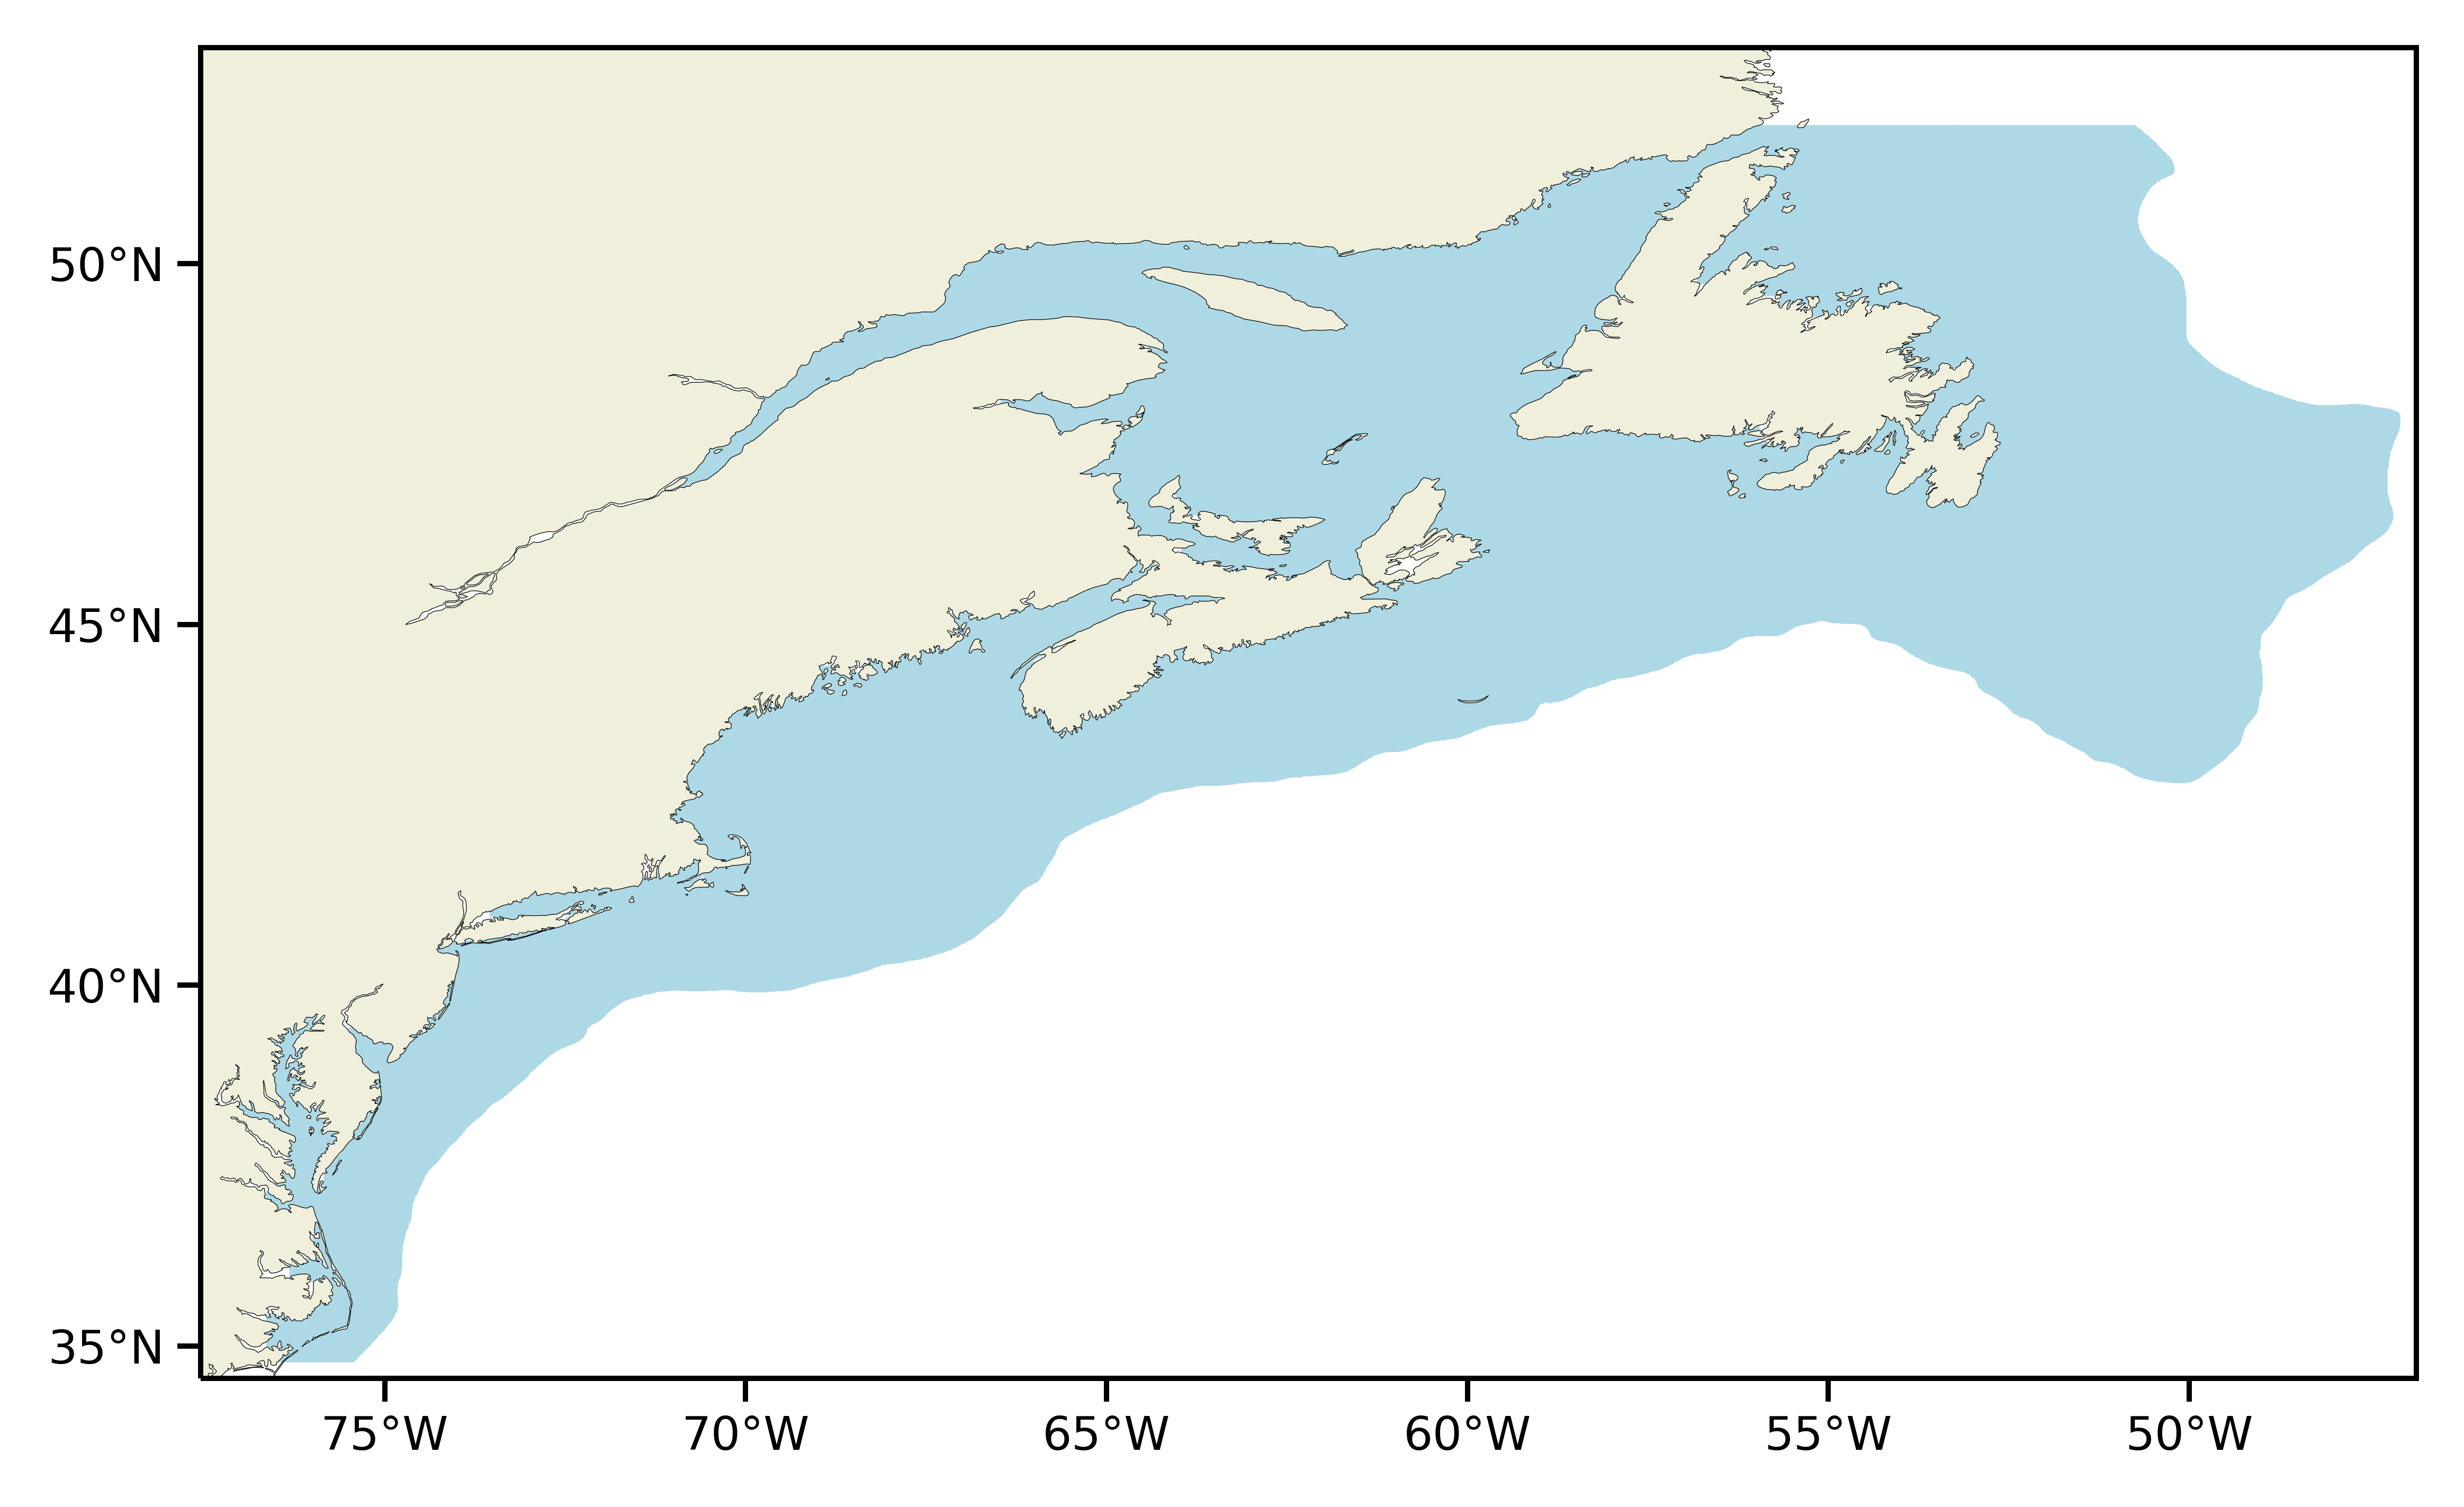

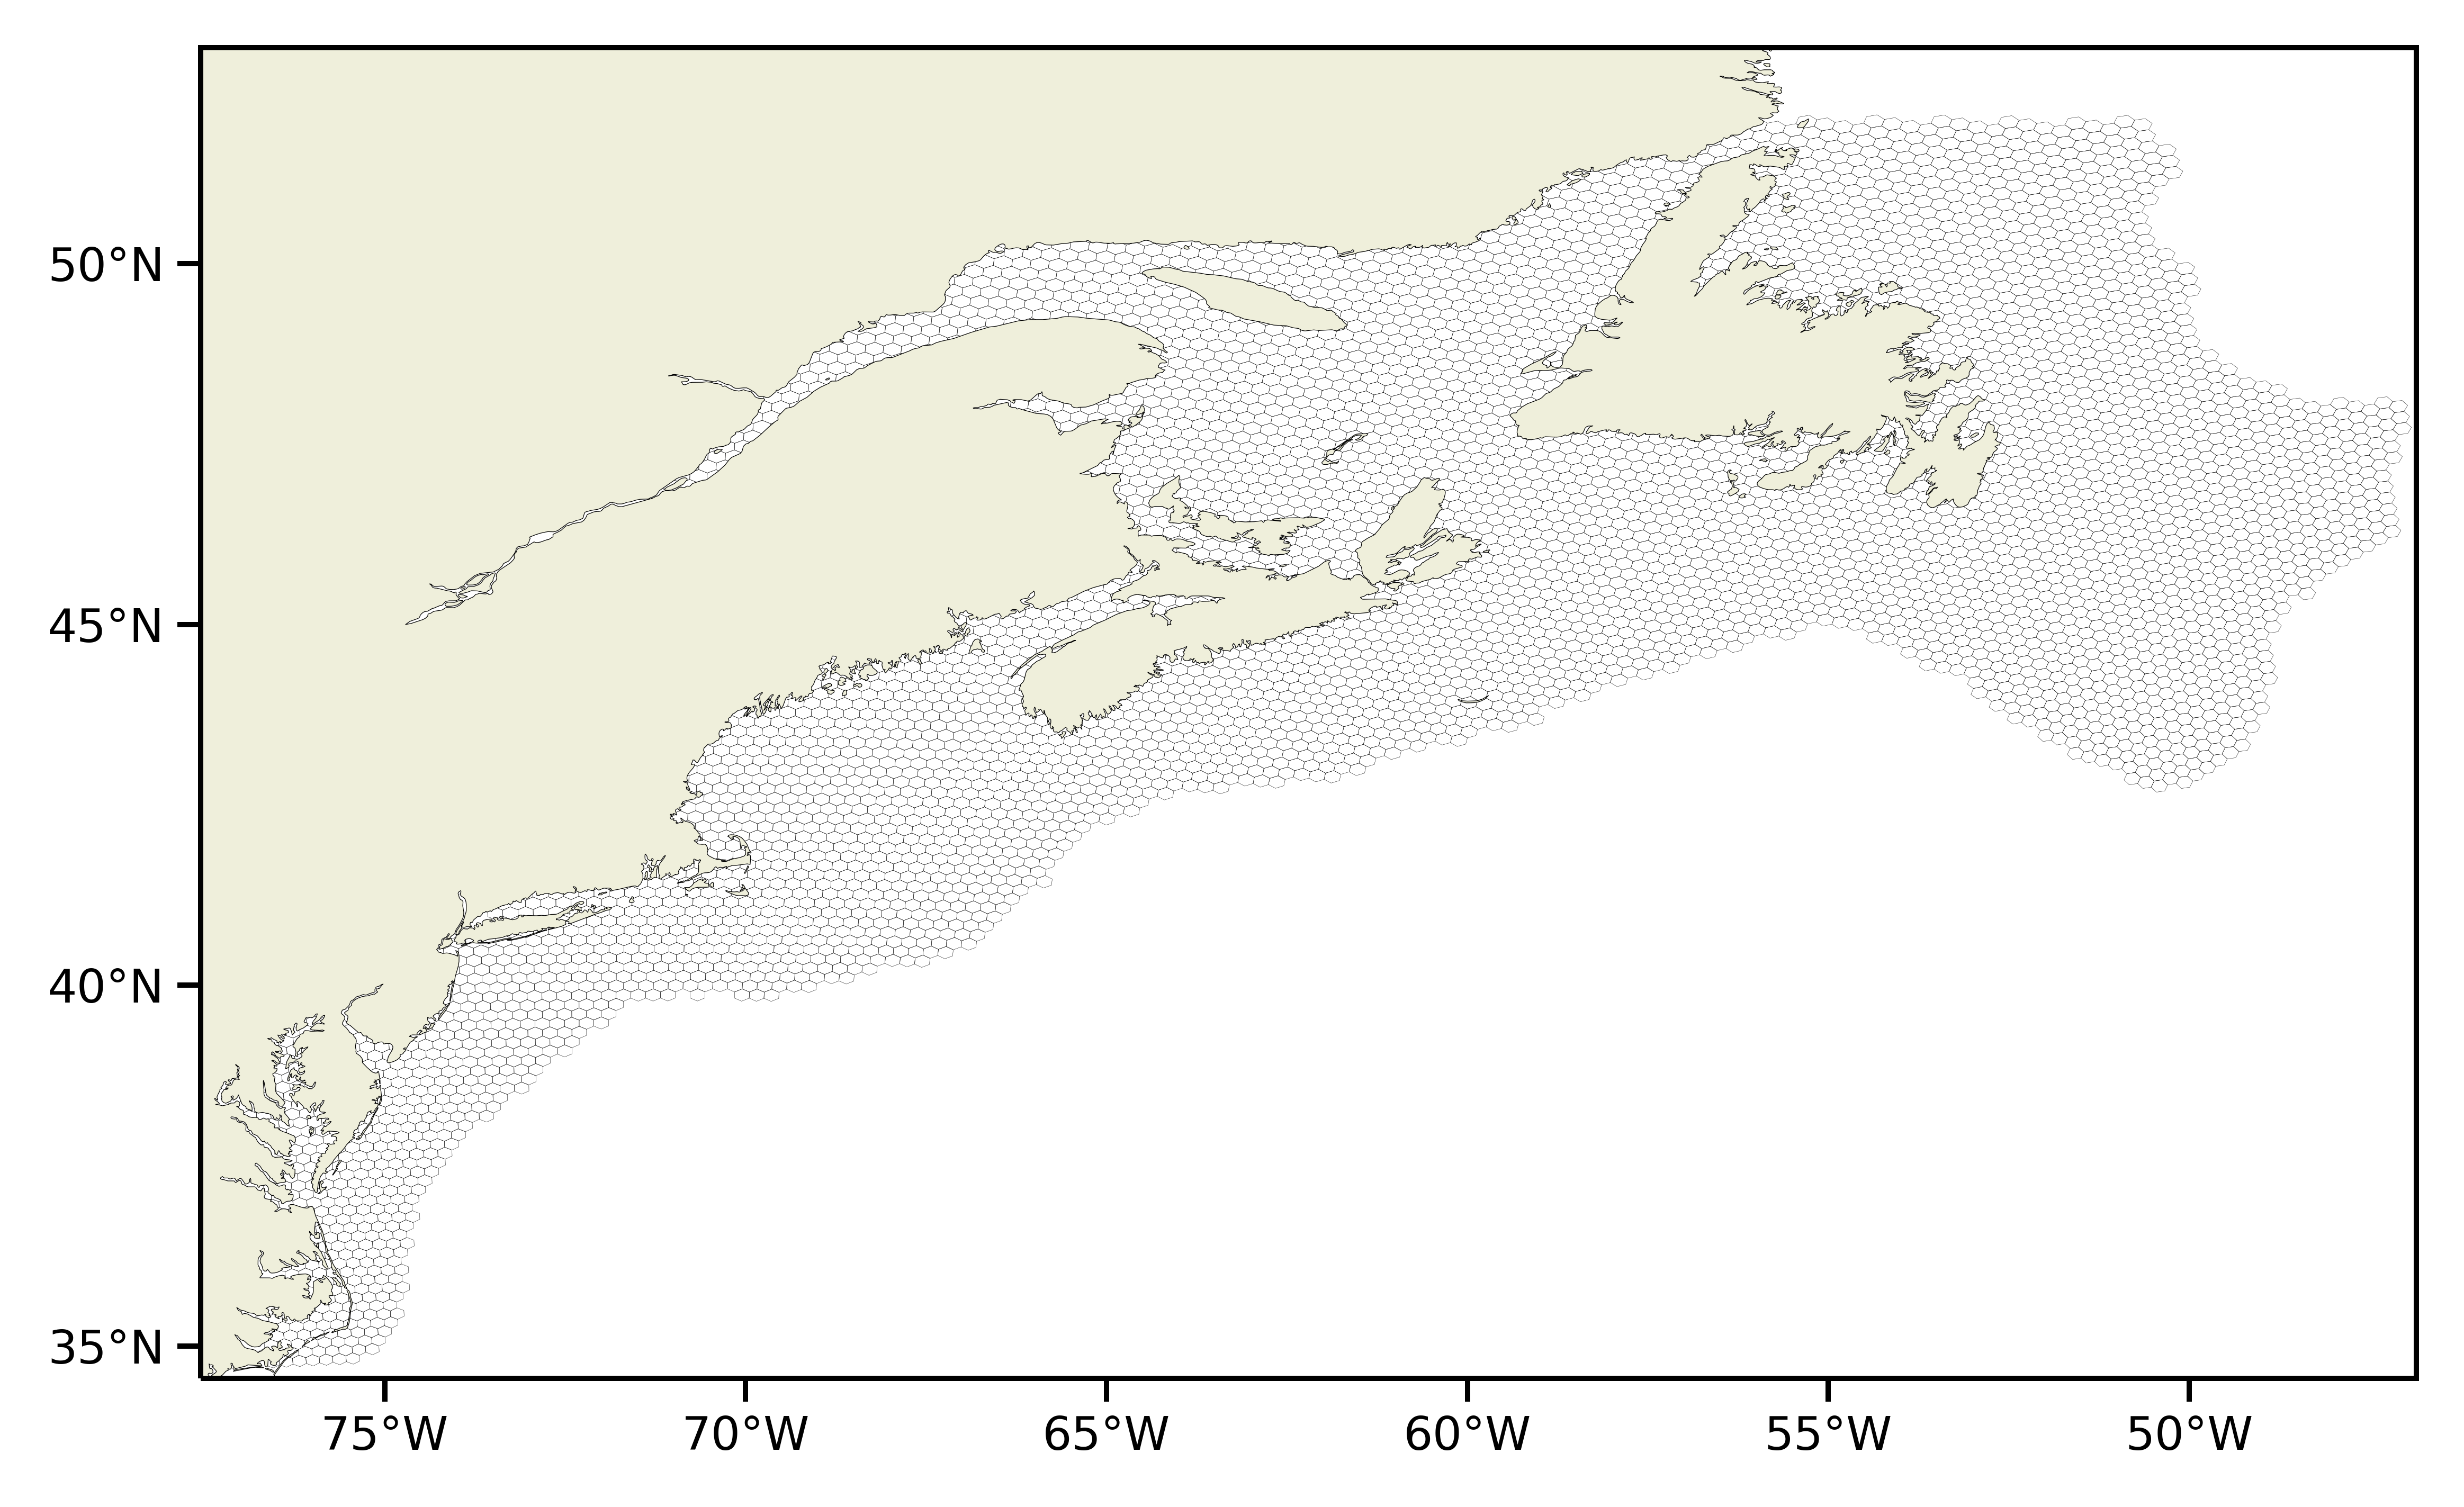

In [9]:
plot_positions(positions[:, 0], positions[:, 1], path=Path.cwd() / 'network' / 'initialized_positions')
plot_hexbins(hexbins, path=Path.cwd() / 'network' / 'initialized_bins')

In [10]:
# Save all nodes in the domain as a mapping of their H3 indices to integers
with open(Path.cwd() / 'network' / 'label_map.pickle', 'wb') as file:
    pickle.dump(label_map, file, protocol=pickle.HIGHEST_PROTOCOL)